In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Generative Learning

The goal of generative models is to learn the probability density function p(x). This probability density effectively describes the behavior of our training data and enables us to generate novel data by sampling from the distribution. Ideally, we want our model to learn a probability p(x) density that will be identical to the density of our data p_data(x).

Note that in most cases, generative models are unsupervised, meaning that they are trained using unlabeled data.

# Latent variable models

Latent variables are a transformation of the data points into a continuous lower-dimensional space.

> In Generative models 'Inference' means: Posterior Estimation. Estimating the hidden (latent) causes (z) that generated the observed data (x).

1. Generation (P(x∣z))
Generation is the process of moving from the latent space (z) to the data space (x).

Goal: To sample a new, realistic data point x (e.g., a new image or text passage).

Mechanism: This is typically handled by the Decoder network in models like VAEs or by the Generator in GANs.

Likelihood: It's represented mathematically by the likelihood or decoding distribution, P(x∣z), which tells you the probability of observing a specific data point x given a latent code z.

2. Inference (P(z∣x))
Inference in the generative context is the reverse: moving from the data space (x) to the latent space (z).

Goal: To find the compressed, underlying representation z (the "code") that most likely produced the observed data x.

Mechanism: This is typically handled by the Encoder network (or the Inference Network) in a VAE.

Posterior Distribution: It's represented mathematically by the posterior distribution, P(z∣x), which tells you the probability of having a specific latent code z given the data x.

The VAE Analogy
In a Variational Autoencoder (VAE), the model is split:

Encoder / Inference Network (Finds z): Takes x and learns to approximate the statistical Inference P(z∣x).

Decoder / Generator Network (Finds x): Takes z and learns the Generation likelihood P(x∣z).

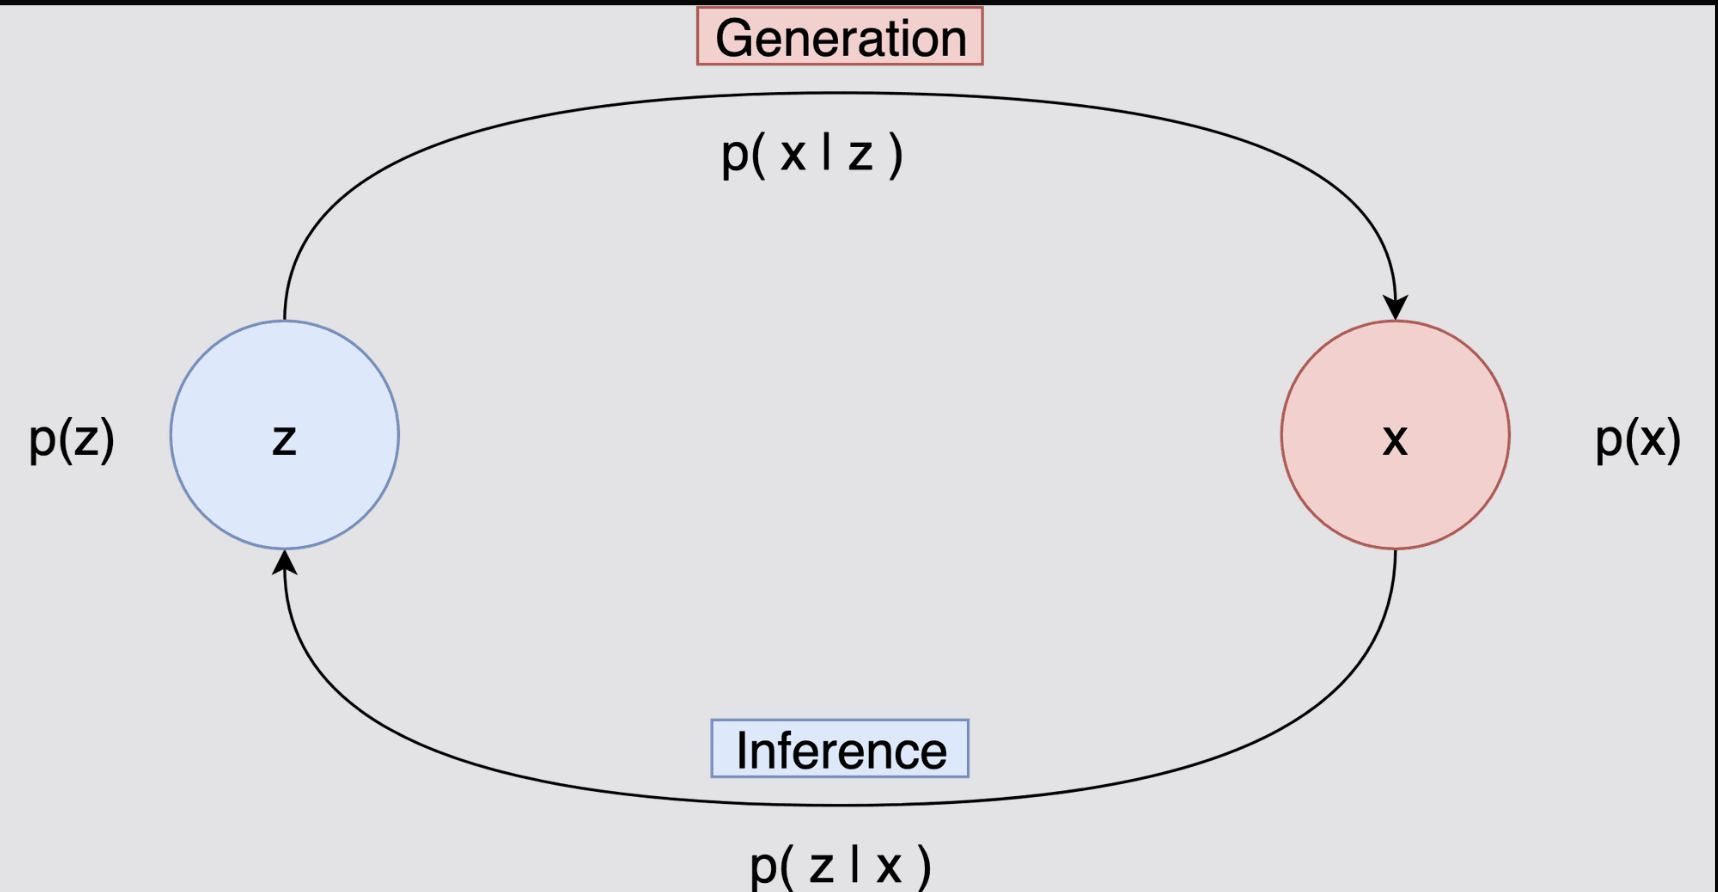

# Basics of Autoencoders

> Autoencoders are simple neural networks such that their output is their input.

Their goal is to learn how to reconstruct the input data.

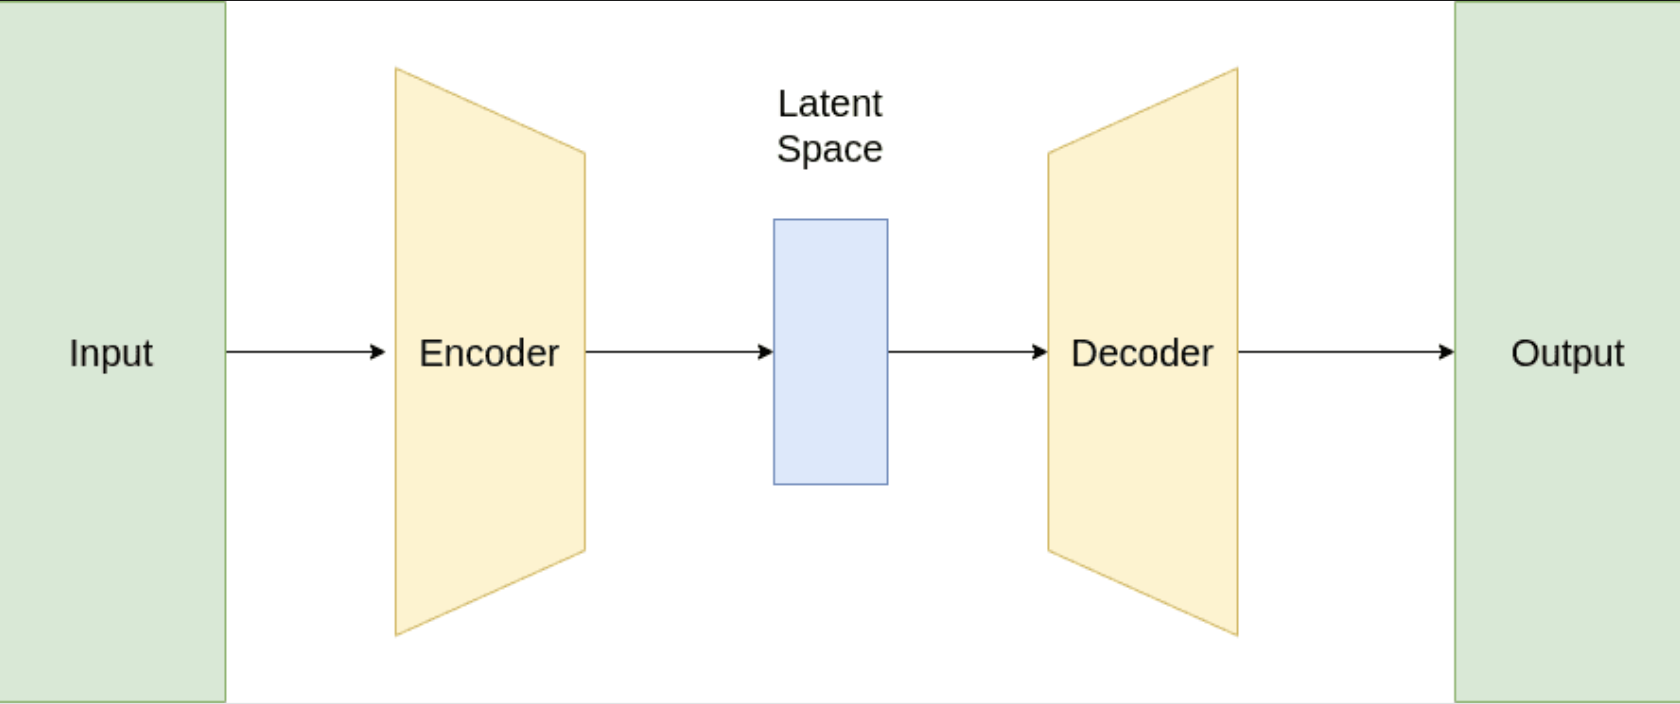

## 🧠 The Autoencoder Concept
An Autoencoder is a network designed to learn a compressed representation (encoding) of its input data. Its training objective is simple: reconstruct its input.

If the network can perfectly reconstruct a complex input (like an image) from a small, constrained code (z), it proves that the code z must contain all the essential information about the input.

## 🧱 The Two-Part Architecture
The Autoencoder is defined by two interconnected parts:

### The Encoder (Compression)
Function: This part of the network receives the original high-dimensional input (x) and compresses it into a lower-dimensional representation.

Output: The latent vector (z), also called the latent code or bottleneck layer.

Latent Space: The text refers to the latent space as a continuous low-dimensional space. This is the compressed feature space where similar inputs are mapped to nearby points. The latent vector z is the desired compressed representation of the input x.

### The Decoder (Decompression/Generation)
Function: This part takes the compressed latent vector (z) and attempts to reconstruct the original high-dimensional input (x).

Training: The loss function (usually Mean Squared Error, MSE) measures the difference between the original input (x) and the decoded output (x_reconstructed). The network trains to minimize this reconstruction error.

## 🎯 Applications of the Latent Vector (z)
The latent vector z is valuable because it isolates the core, independent factors of variation in the data, leading to many practical applications:

### Core Representation Tasks
Compression / Dimensionality Reduction: Once trained, the Decoder can be discarded, and the Encoder is used to transform high-dimensional data into the compact z vector, saving space and computation.

### Practical Novelty Tasks

1. Data Denoising: The network is trained using noisy images as input and clean images as the target output (a Denoising Autoencoder). Because the latent space is low-dimensional, it cannot encode the high-frequency random noise, forcing the Decoder to reconstruct only the learned, clean features.

2. Anomaly Detection: An AE is trained exclusively on data belonging to a single category (e.g., normal machine sensor readings). If the network is fed an anomaly (e.g., a broken sensor reading), it cannot reconstruct it well because it has never seen that type of data. The resulting large reconstruction error signals an anomaly.

3. Training Data Augmentation: By manipulating or sampling new vectors in the latent space and feeding them to the Decoder, you can generate variations of the original training data.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),  # [batch, 96, 2, 2]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

## ConvTranspose2d (Convolutional Transpose 2D)

This is a layer in PyTorch used for upsampling or increasing the spatial resolution of feature maps. It is often referred to as a deconvolution layer, though this term is technically misleading.

Its relationship to Conv2d is that it performs the reverse connectivity pattern of a normal convolution.

ConvTranspose2d works by taking a small input feature map and expanding it into a larger output feature map. It achieves this by performing a convolution operation on a padded, sparsely populated version of the input, effectively distributing each input pixel to a larger receptive field in the output.

Primary Use: Upsampling the spatial dimensions (Height and Width) in the decoder part of models like Autoencoders, VAEs, and Generative Adversarial Networks (GANs).

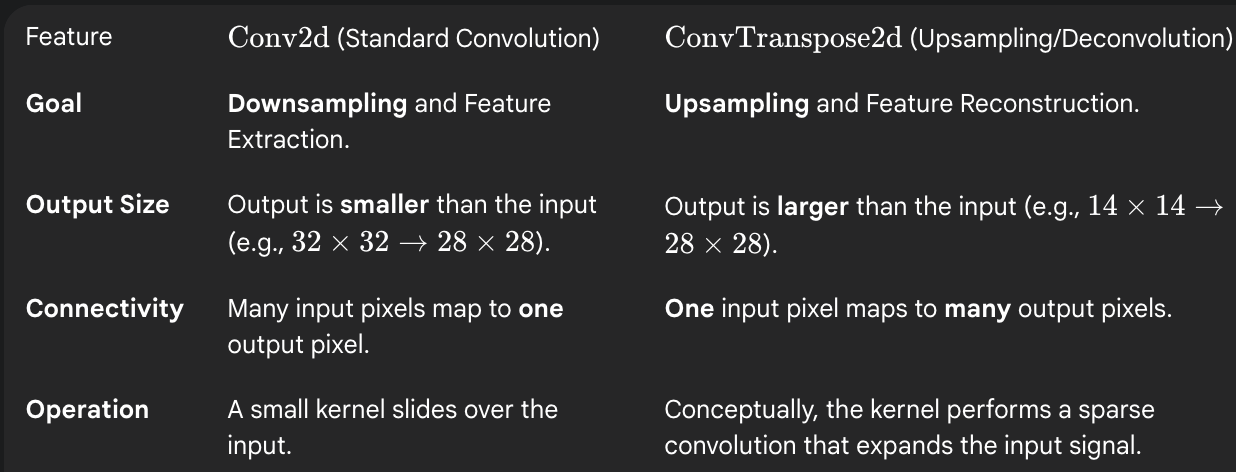

# 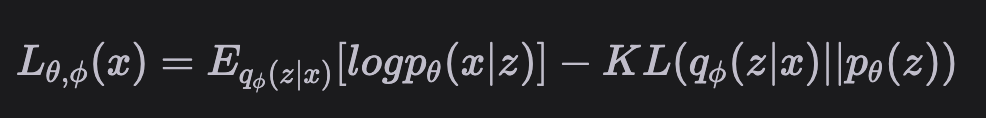Variational Autoencoder: Theory

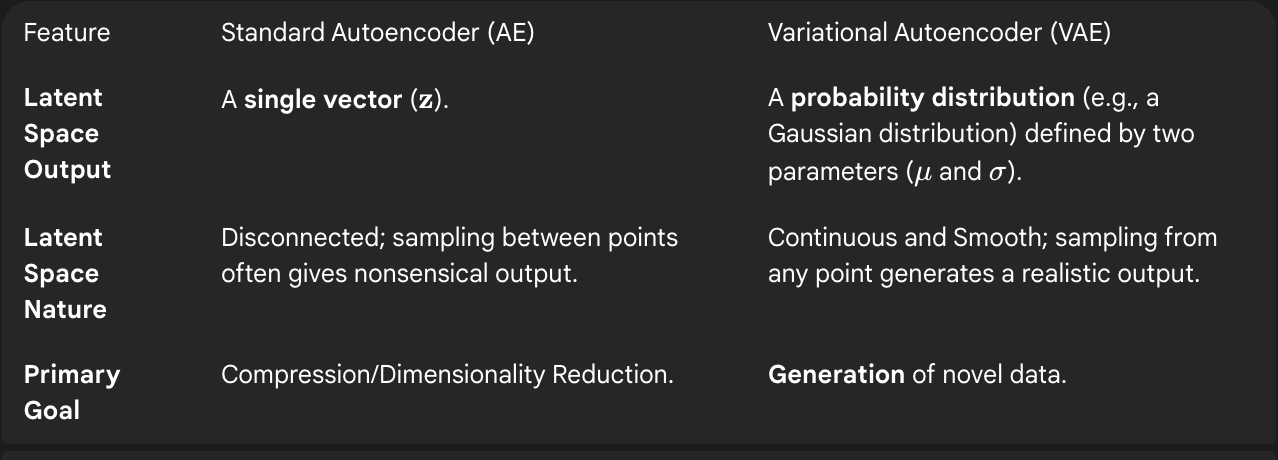

The move to a probability distribution is necessary because if you want to generate new data, you must be able to sample from the latent space smoothly. If the latent space is a patchy collection of discrete points (as in an AE), sampling between them yields garbage.

## The Inference Problem and q(z∣x)
In the VAE, the goal is to find the true posterior distribution P(z∣x)—the probability of the code z given the data x. This is the statistical inference problem.

The Problem: P(z∣x) is computationally intractable (impossible to calculate directly).

The VAE Solution: The Encoder network is designed to approximate this intractable posterior using a simpler, traceable distribution, q(z∣x), which is called the variational posterior.

Implementation: q(z∣x) is typically chosen to be a Gaussian distribution N(μ(x),σ(x)). The Encoder, therefore, outputs two vectors: one for the mean (μ) and one for the standard deviation (σ).

## The Central Problem: Backpropagating Through Sampling
The text highlights the most significant technical hurdle in training VAEs:

The Setup: The Decoder needs a specific latent vector, z, to reconstruct the image. This vector z is drawn by sampling from the distribution output by the Encoder: z∼N(μ,σ).

The Problem: Sampling is a stochastic (random) operation. During the backward pass, when PyTorch tries to calculate the gradient of the loss with respect to the Encoder's parameters (μ and σ), it cannot calculate the derivative of a random process. You cannot backpropagate through a sampling layer.

## ELBO Loss:

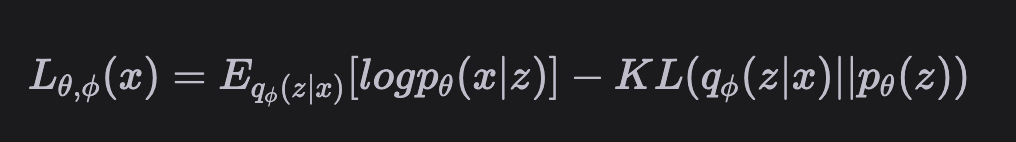

First term - controls how well the VAE reconstructs a data point x from a sample z of the variational posterior, and it is known as negative reconstruction error. When data points are binary this term can be proved to be binary cross entropy i.e. `torch.nn.BCELoss(reduction = 'sum)`.

Second term i.e. KL Divergence controls how close the variational posterior is to the prior. It also has closed form solution if we assume prior distribution to be Gaussian.

The VAE simultaneously trains for two competing goals:

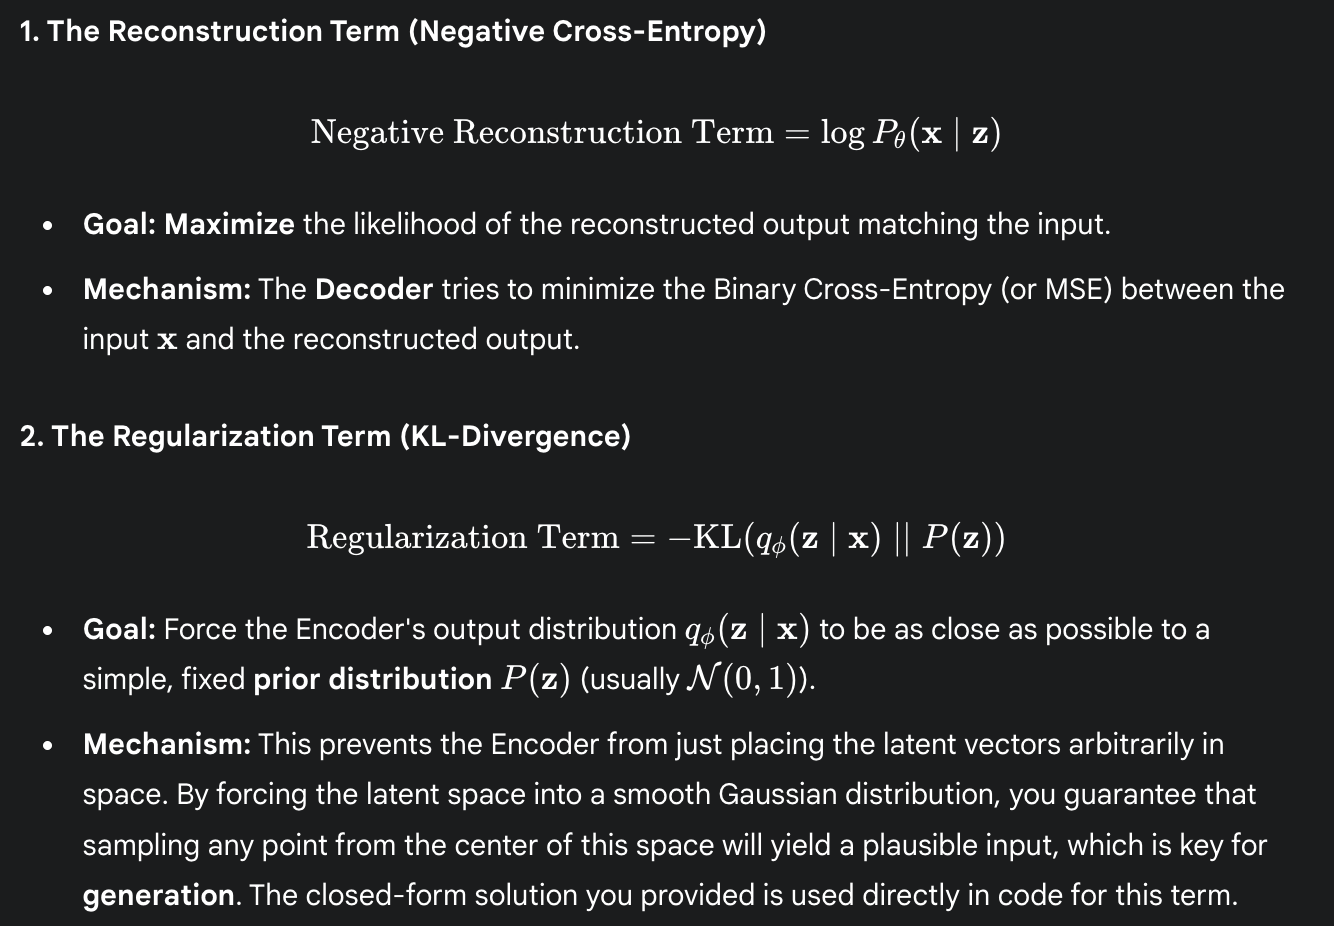

## Why Reparameterization?

The ELBO loss = Reconstruction Term + Regularization term.

The regularization term (KL Divergence) has closed form solution & no sampling here so good to go for backpropagation.

#### The Reconstruction term:
This term is an expected value calculated over the variational posterior q_ϕ(z∣x). To compute this expected value in practice, we use Monte Carlo estimation: we draw one (or a few) samples of z and use that to approximate the expectation.

(Sampling is a non-differentiable, stochastic step)

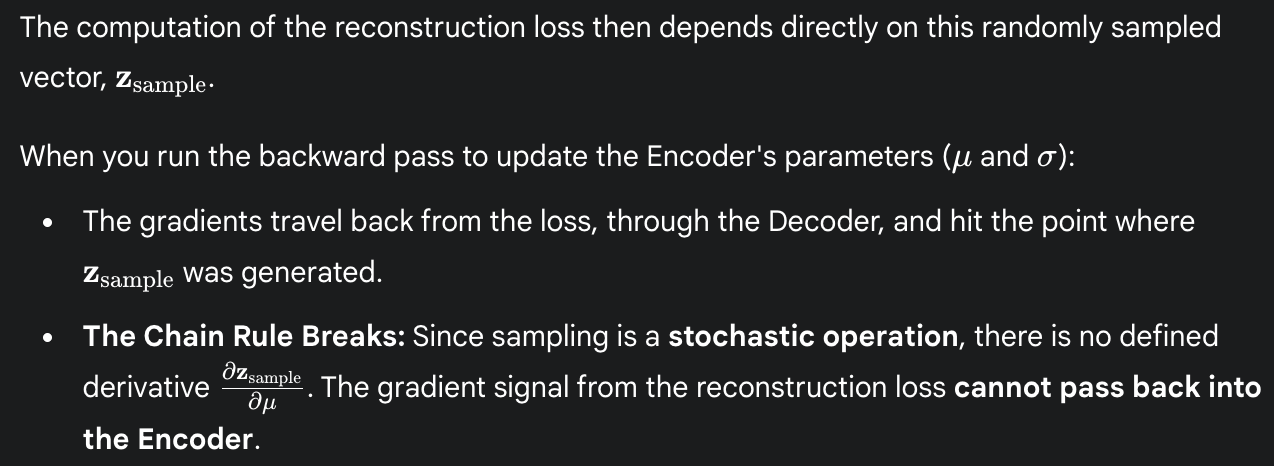

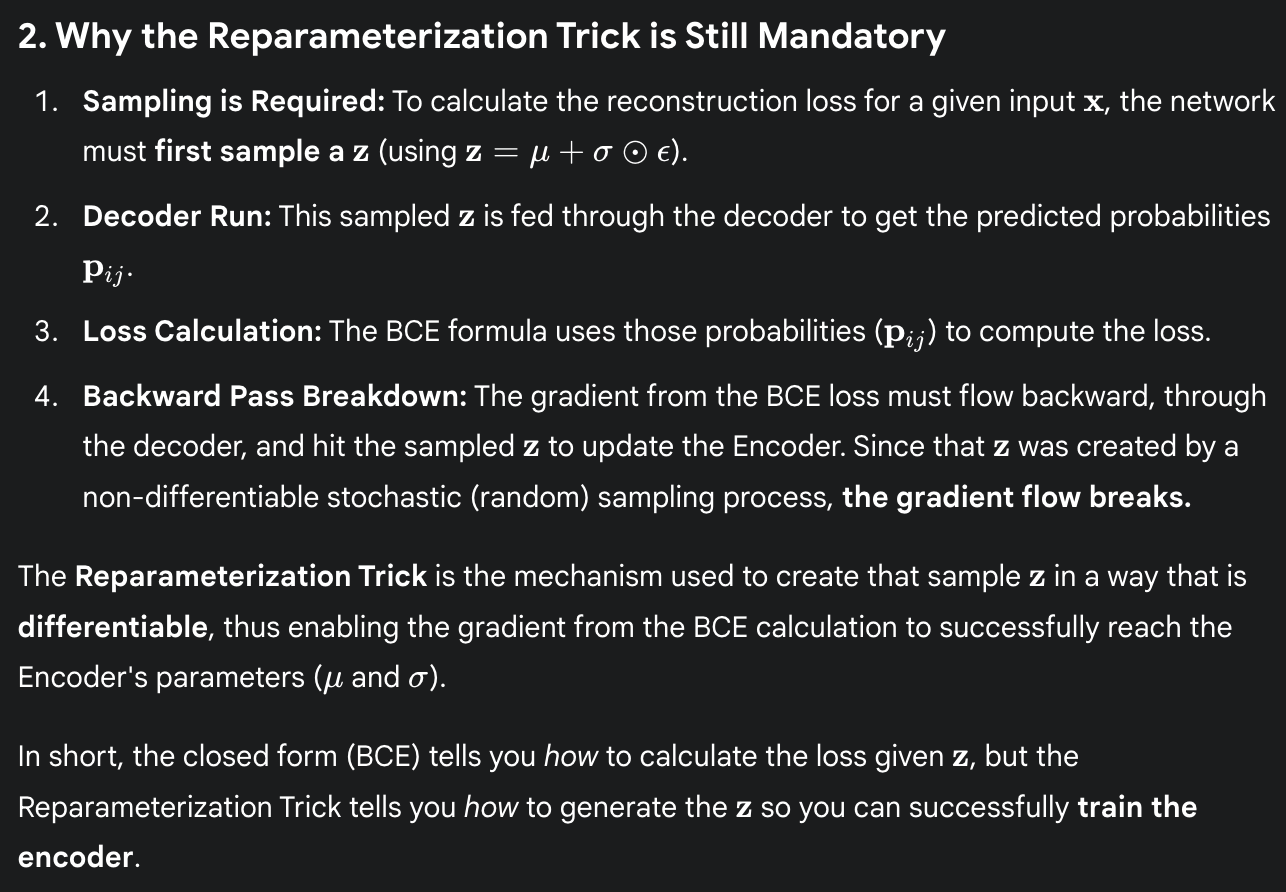

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.features =16
        # encoder
        self.enc1 = nn.Linear(in_features=3072, out_features=128)
        self.enc2 = nn.Linear(in_features=128, out_features=self.features * 2)

        # decoder
        self.dec1 = nn.Linear(in_features=self.features, out_features=128)
        self.dec2 = nn.Linear(in_features=128, out_features=3072)

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, self.features)
        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # generate sample of the same size
        sample = mu + (eps * std)  # sampling as if coming from the input space
        return sample
    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model,training_data):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss(reduction='sum')

    running_loss = 0.0

    for epoch in range(1):  # loop over the dataset multiple times

        for i, data in enumerate(training_data, 0):
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            reconstruction, mu, logvar = model(inputs)
            bce_loss = criterion(reconstruction, inputs)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    PATH = './cifar_net.pth'
    torch.save(model.state_dict(), PATH)

    print('Finished Training')

As you can see from the code, during training:

We pass a data point to the encoder, which will output the mean and the log-variance of the approximate posterior.

We apply the reparameterization trick.

We passed the reparameterized samples to the decoder, which will output the likelihood.

We compute the ELBO and backpropagate the gradients.

To generate a new data point:

We sample a set of latent vectors from the normal prior distribution.

We obtain the latent variables from the encoder.

The decoder will transform the latent variable of the sample to a new data point.

# TODO:

If you are starting to feel really comfortable with Pytorch, try the following task: Write your own VAE from scratch, and train in on the CIFAR10 data from the previous chapters. You can use convolutional networks for both the encoder and the decoder and you can borrow code from this or previous lessons.

So all you need to do is:

Define a Convolutional VAE.
Load the CIFAR10 data.
Train the VAE.